# MDD full and stochastic - Volve data

**Author: M.Ravasi**

This notebook applies multi-dimensional deconvolution to up/down separared Volve data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.interpolate import RegularGridInterpolator

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *

from segyshot import SegyShot
from wavsep_utils import *
from stochmdd import MDDminibatch

## Up/down data loading

In [2]:
nshots, nrecs, nt = 119, 180, 5000
dr = 25
dt = 0.002

r = np.arange(nrecs) * dr
torig = np.arange(nt) * dt
pup2d = np.zeros((nshots, nrecs, nt))
pdown2d  = np.zeros((nshots, nrecs, nt))

for ishot in range(nshots):
    pup2d[ishot] = np.fromfile('Volveimaging/pup_shot%d.bin' % ishot, dtype=np.float32).reshape(nt, nrecs).T
    pdown2d[ishot] = np.fromfile('Volveimaging/pdown_shot%d.bin' % ishot, dtype=np.float32).reshape(nt, nrecs).T

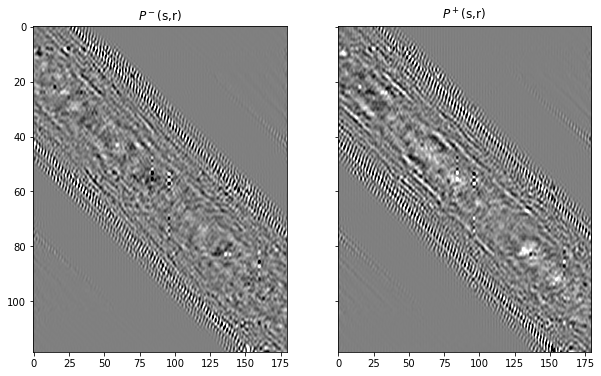

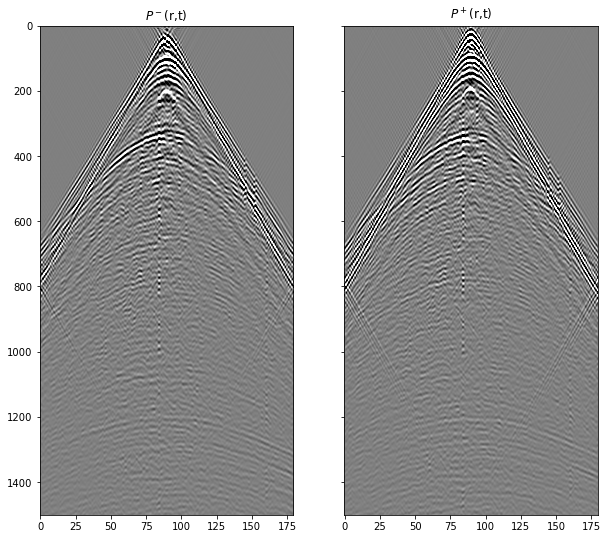

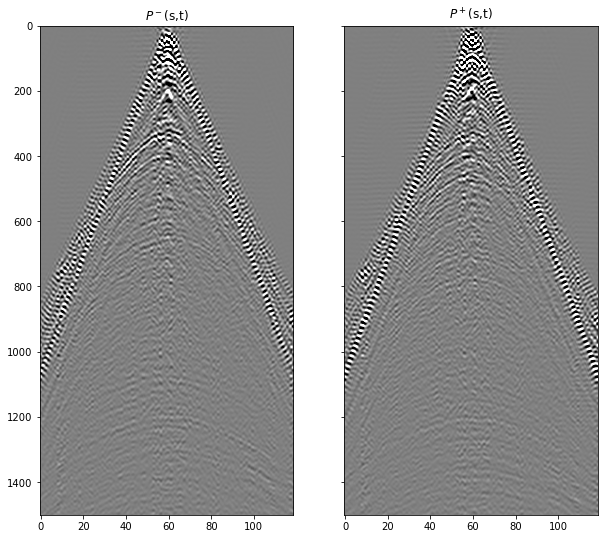

In [3]:
clip = 4e5

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
axs[0].imshow(pup2d[..., 500], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title(r'$P^-$(s,r)')
axs[0].axis('tight')
axs[1].imshow(pdown2d[..., 500], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title(r'$P^+$(s,r)')
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 9))
axs[0].imshow(pup2d[nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title(r'$P^-$(r,t)')
axs[0].axis('tight')
axs[1].imshow(pdown2d[nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title(r'$P^+$(r,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0)
plt.savefig('Figs/Volve_pud_shot%d' % (nshots//2))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 9))
axs[0].imshow(pup2d[:, nrecs//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title(r'$P^-$(s,t)')
axs[0].axis('tight')
axs[1].imshow(pdown2d[:, nrecs//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title(r'$P^+$(s,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0);

## Single virtual source MDD

In [4]:
nt = 3000
t = torig[:nt]
dt = t[1]-t[0]
dr = 25
nfmax = 450
nfft = nt

# Rearrange data
pup = pup2d.transpose(2,0,1)[:nt]
pdown = pdown2d.transpose(2,0,1)[:nt]

# Rescale to get values around 1)
pdown = pdown / 4e7
pup = pup / 4e7

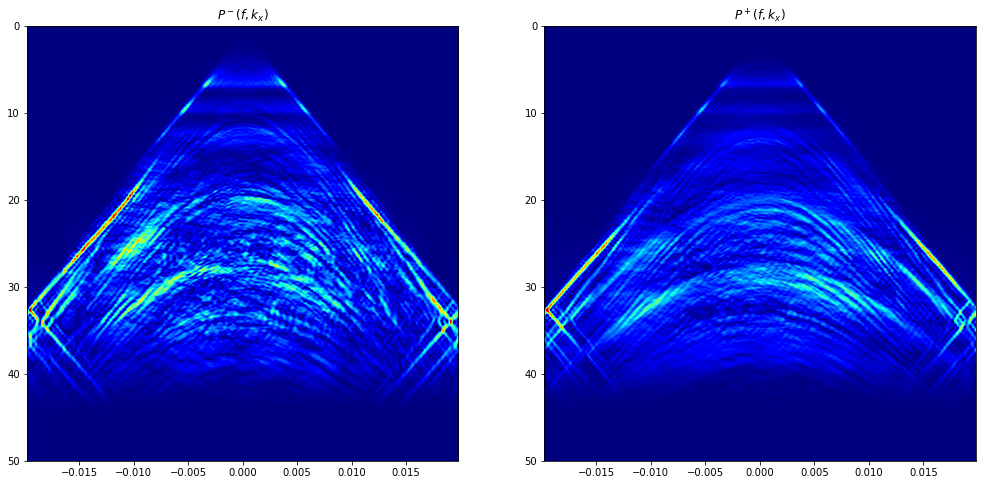

In [5]:
FFTop = FFT2D(dims=[nrecs, nt], nffts=[nrecs, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[:, nshots//2].T.flatten()).reshape(nrecs, nfft)
PDOWN = (FFTop*pdown[:, nshots//2].T.flatten()).reshape(nrecs, nfft)

clip = 0.1
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
axs[0].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nrecs//2-1], FFTop.f1[nrecs//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PUP).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^-(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(50, 0);           
axs[1].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nrecs//2-1], FFTop.f1[nrecs//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^+(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);

### Benchmark MDD

In [6]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=1, dt=dt, dr=dr, 
            twosided=False, transpose=False)
# Adjoint
Radj = MDCop.H * pup[:, :, nrecs//2].ravel()
Radj = np.real(Radj).reshape(nt, nrecs)

In [7]:
# Inverse
niter = 40
Rinv, _, _, _, _, Rinv_res = \
    cgls(MDCop, pup[:, :, nrecs//2].ravel(), niter=niter, 
         x0=np.zeros((nt, nrecs)).ravel(), damp=1e-9, tol=0., show=1)
Rinv = np.real(Rinv).reshape(nt, nrecs)
Rinv_res = Rinv_res**2 / (nt * nshots)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, nshots)

CGLS
-----------------------------------------------------------
The Operator Op has 357000 rows and 540000 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 40
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         5.4111e-06         9.3835e-01      9.3835e-01
     2         1.2725e-05         7.4774e-01      7.4774e-01
     3         1.9025e-05         6.5149e-01      6.5149e-01
     4         2.0754e-05         5.7936e-01      5.7936e-01
     5         2.1738e-05         5.1834e-01      5.1834e-01
     6         2.4068e-05         4.7721e-01      4.7721e-01
     7         2.5556e-05         4.4207e-01      4.4207e-01
     8         2.9813e-05         4.1467e-01      4.1467e-01
     9         3.7286e-05         3.9238e-01      3.9238e-01
    10         4.5868e-05         3.7279e-01      3.7279e-01
    20         7.3537e-05         2.7221e-01      2.7221e-01
    30         5.2512e-05         2.3181e-01   

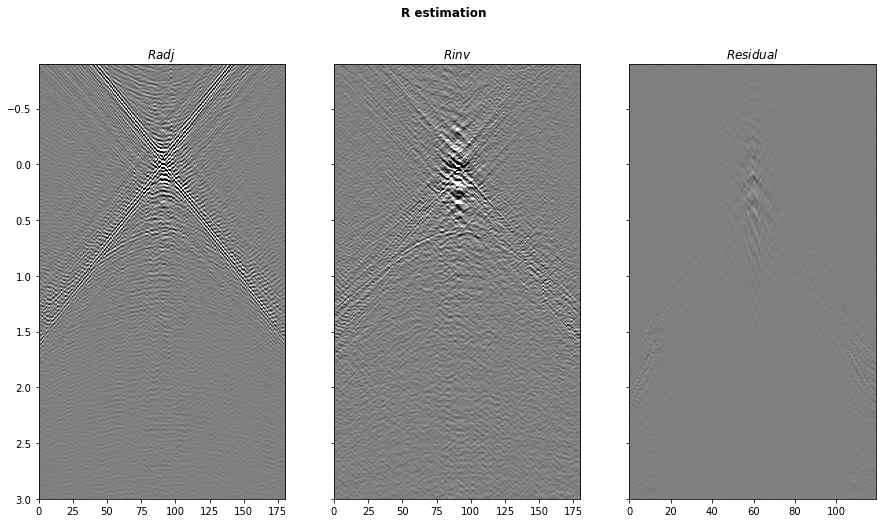

In [8]:
clip = 0.1
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj,axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv,axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift(pup[:, :, nrecs//2]-pupinv,axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
              extent = (0, nshots, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(3, -.9);

### Steepest descent MDD

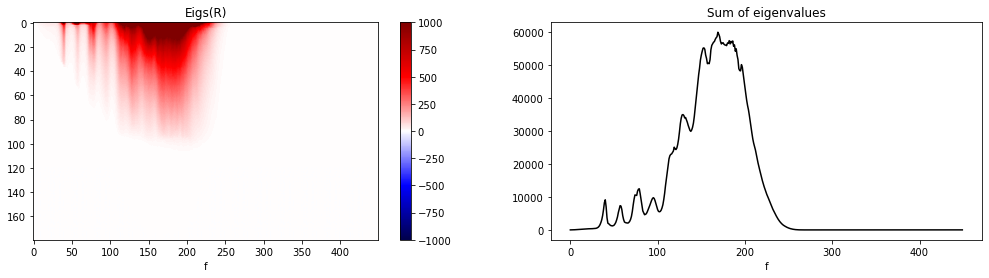

In [9]:
eigmax = (MDCop.H @ MDCop).eigs(neigs=1)

PDOWN = dr * dt * np.sqrt(nt) * np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

eigs = np.linalg.eig(np.matmul(np.conj(PDOWN.transpose(0,2,1)), PDOWN))[0]
eigs = np.fliplr(np.sort(np.abs(eigs), axis=1))

fig, axs = plt.subplots(1, 2, figsize=(17, 4))
im = axs[0].imshow(eigs.T, cmap='seismic', vmin=-1e3, vmax=1e3)
axs[0].set_title('Eigs(R)')
axs[0].set_xlabel('f')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
axs[1].plot(np.sum(eigs, axis=1), 'k')
axs[1].set_title('Sum of eigenvalues')
axs[1].set_xlabel('f');

In [10]:
alphamax1 = 2. / eigs.max() 
alphamax = 2. / np.real(eigmax[0])
print(alphamax1, alphamax)

# Identify learning-rate based on steepest descent first step / analytical upper bound.
# To make it equivalent to analytic steepest descent, denominator compensates for 
# different norm used in torch which is normalized by number of elements
lrstmax = alphamax # from steepest descent notebook
lrstmax * ((nt*nshots)/2)

0.0002588242582488915 0.00025882425824889053


46.200130097426964

### Stochastic MDD

In [11]:
nepochs = niter
batch_size = 32

no_of_batches= int(np.ceil(nshots/batch_size))
lossdict = {}
avgdict = {}
lossepochdict = {}
mdict = {}

In [12]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[..., nrecs//2])

In [15]:
lr = {}
lr[32] = 30

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], _, _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

Initial Gradient norm: 6.499953e-08, scaled by lr: 5.849957e-05
Initial Gradient norm as np.linalg.norm: 1.223760e+01, scaled by nbatches:  4.550858e+01
epoch:   5, loss : 8.3883e-07, loss avg : 9.0122e-07
epoch:  10, loss : 5.3955e-07, loss avg : 5.5738e-07
epoch:  15, loss : 4.8181e-07, loss avg : 4.3426e-07
epoch:  20, loss : 4.4216e-07, loss avg : 3.6592e-07
epoch:  25, loss : 3.6419e-07, loss avg : 3.2209e-07
epoch:  30, loss : 1.6884e-07, loss avg : 2.8056e-07
epoch:  35, loss : 3.0543e-07, loss avg : 2.6953e-07
epoch:  40, loss : 2.2693e-07, loss avg : 2.4622e-07
Final Model norm: 4.152044e-03


In [16]:
# First loss 
np.sum(np.abs(pup.reshape(-1).numpy())**2) / (len(pup.reshape(-1))), lossepochdict['SGD'][0], Rinv_res[0]

(3.5396371096525175e-06, 3.5396371096525154e-06, 3.5396371096525167e-06)

In [17]:
print(np.sum(np.abs(model.detach().numpy().ravel())**2))

0.00415204444477357


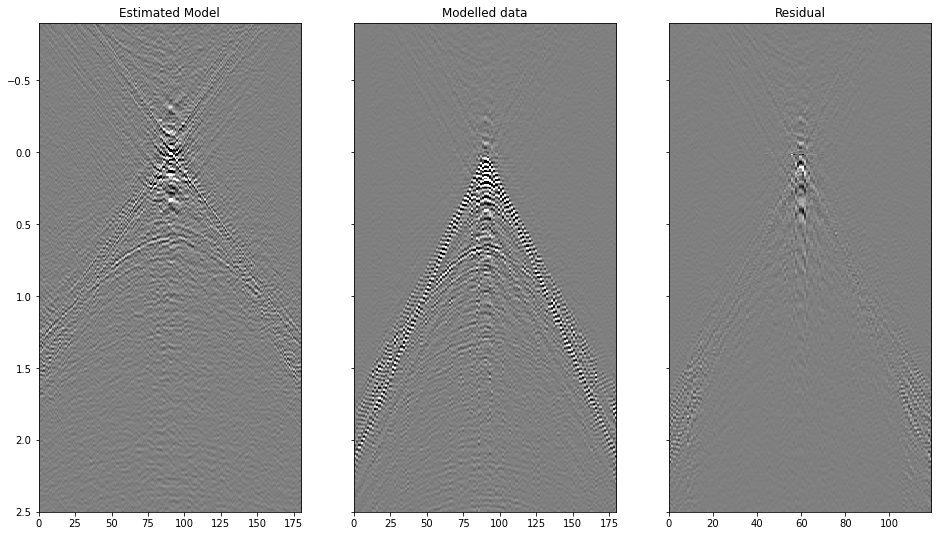

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [19]:
lr = {}
lr[32] = 10

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], _, _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()

Initial Gradient norm: 6.499953e-08, scaled by lr: 6.499953e-06
Initial Gradient norm as np.linalg.norm: 1.223760e+01, scaled by nbatches:  4.550858e+01
epoch:   5, loss : 6.7656e-07, loss avg : 7.0166e-07
epoch:  10, loss : 4.1588e-07, loss avg : 4.3517e-07
epoch:  15, loss : 3.6962e-07, loss avg : 3.5469e-07
epoch:  20, loss : 3.8394e-07, loss avg : 3.1924e-07
epoch:  25, loss : 3.2241e-07, loss avg : 2.9063e-07
epoch:  30, loss : 1.5299e-07, loss avg : 2.6324e-07
epoch:  35, loss : 3.1546e-07, loss avg : 2.6726e-07
epoch:  40, loss : 2.2304e-07, loss avg : 2.5074e-07
Final Model norm: 3.784881e-03


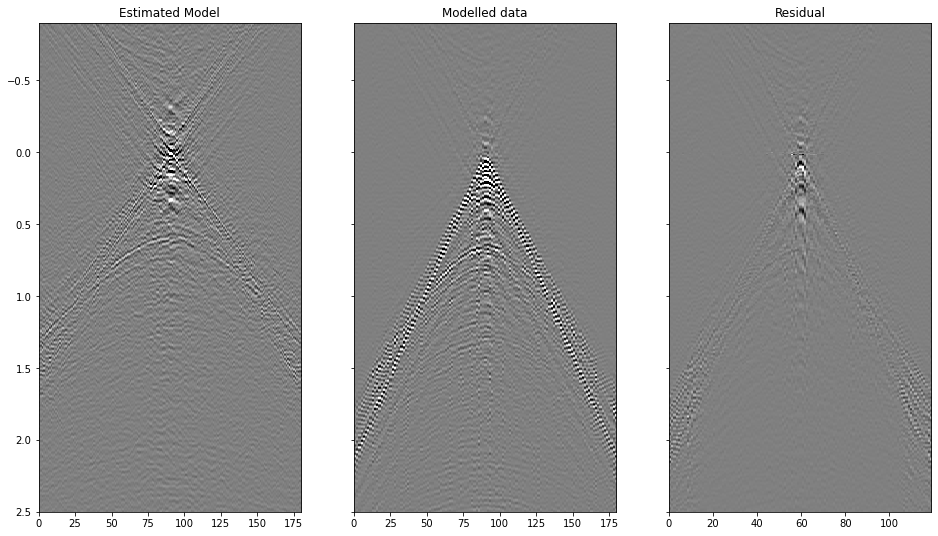

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [21]:
lr = {}
#lr[21] = ?
lr[32] = 10
#lr[64] = ?

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], _, lr = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5,
                              kwargs_sched=dict(gamma=0.97, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

Initial Gradient norm: 6.499953e-08, scaled by lr: 6.499953e-06
Initial Gradient norm as np.linalg.norm: 1.223760e+01, scaled by nbatches:  4.550858e+01
epoch:   5, loss : 7.3137e-07, loss avg : 7.9832e-07
epoch:  10, loss : 5.2411e-07, loss avg : 5.6343e-07
epoch:  15, loss : 5.5557e-07, loss avg : 5.0697e-07
epoch:  20, loss : 5.6398e-07, loss avg : 4.8338e-07
epoch:  25, loss : 5.0154e-07, loss avg : 4.6722e-07
epoch:  30, loss : 2.4633e-07, loss avg : 4.4340e-07
epoch:  35, loss : 5.0334e-07, loss avg : 4.5854e-07
epoch:  40, loss : 3.5042e-07, loss avg : 4.4609e-07
Final Model norm: 2.060383e-03


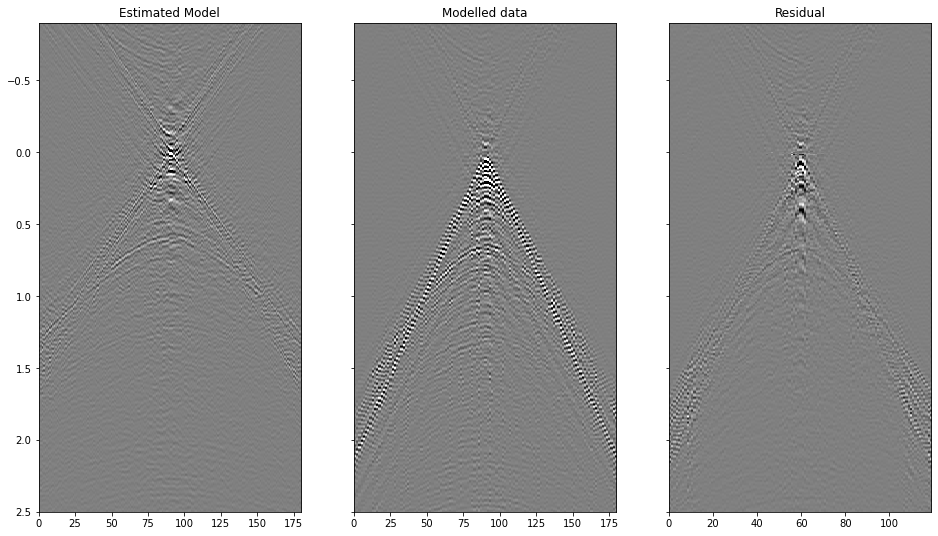

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

### Comparison

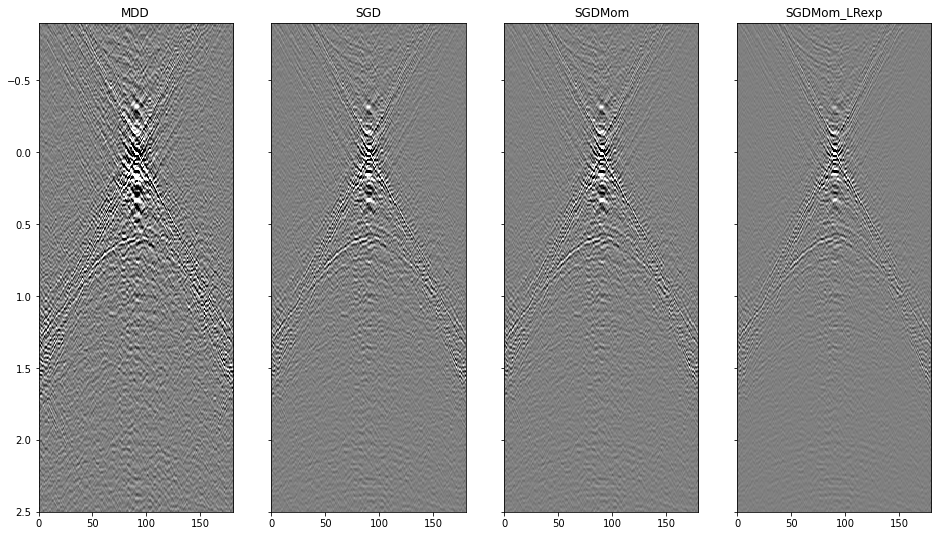

In [23]:
clip = 0.07
fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.fftshift(Rinv,axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):

    axs[imod+1].imshow(np.fft.fftshift(mdict[mod],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
                       extent = (0, nrecs, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
axs[-1].set_ylim(2.5, -.9);
plt.savefig('Figs/Volvesingle_solutions_batch%d_nepoch%d' % (batch_size, nepochs))

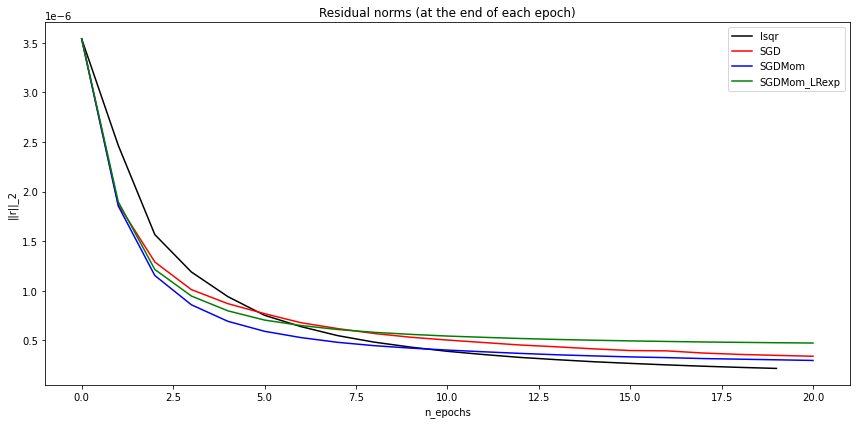

In [24]:
colors = ('r', 'b', 'g')
nepochs = 20

fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/Volvesingle_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

In [25]:
np.savez('Data/mdd_volvereal_single_iter%d_batch%d' % (niter, batch_size), t=t,
         Radj=Radj, Rinv=Rinv, Rsgd=mdict['SGD'], Rnsgd=mdict['SGDMom'], 
         Rnsgdexp=mdict['SGDMom_LRexp'])

## Multi virtual source MDD

In [26]:
# 10 vs
#reciprocity=False
#ivs = 5
#nvsin = nrecs//2-5
#nvsend = nrecs//2+6

# all vs
reciprocity = True #False
ivs = nrecs//2
nvsin = 0
nvsend = nrecs

nvs = nvsend-nvsin
nvs

180

In [27]:
nt = 3000
t = torig[:nt]
dt = t[1]-t[0]
dr = 25
nfmax = 450
nfft = nt

# Rearrange data
pup = pup2d.transpose(2,0,1)[:nt]
pdown = pdown2d.transpose(2,0,1)[:nt]

# Rescale to get values around 1)
pdown = pdown / 4e7
pup = pup / 4e7

### Benchmark MDD

In [28]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=nrecs, dt=dt, dr=dr, 
            twosided=False, transpose=False)

# Reciprocity prec
if reciprocity:
    Recop =  0.5 * (Identity(nt * nrecs * nrecs) + \
            Transpose((nt, nrecs, nrecs), (0, 2, 1)))
    MDCop = MDCop * Recop

# Adjoint
Radj = MDCop.H * pup[:, :, nvsin:nvsend].ravel()
Radj = np.real(Radj).reshape(nt, nrecs, nvs)

In [29]:
# Inversion
niter = 40
Rinv, _, _, _, _, bench_resnorm = \
    cgls(MDCop, pup[:, :, nvsin:nvsend].ravel(), niter=niter, 
         x0=np.zeros((nt, nrecs, nvs)).ravel(), damp=1e-9, tol=0., show=1)
Rinv = np.real(Rinv).reshape(nt, nrecs, nrecs)
bench_resnorm = bench_resnorm**2 / (nt * nshots * nvs)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, nshots, nvs)

CGLS
-----------------------------------------------------------
The Operator Op has 64260000 rows and 97200000 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 40
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1        -1.8079e-04         1.2250e+01      1.2250e+01
     2        -7.9342e-04         1.0732e+01      1.0732e+01
     3        -1.5385e-03         9.6509e+00      9.6509e+00
     4        -2.0374e-03         9.1082e+00      9.1082e+00
     5        -2.4983e-03         8.6890e+00      8.6890e+00
     6        -2.8859e-03         8.3779e+00      8.3779e+00
     7        -3.1778e-03         8.1382e+00      8.1382e+00
     8        -3.3773e-03         7.9594e+00      7.9594e+00
     9        -3.5252e-03         7.8083e+00      7.8083e+00
    10        -3.6370e-03         7.6944e+00      7.6944e+00
    20        -3.8970e-03         7.2020e+00      7.2020e+00
    30        -4.1919e-03         7.0795e+0

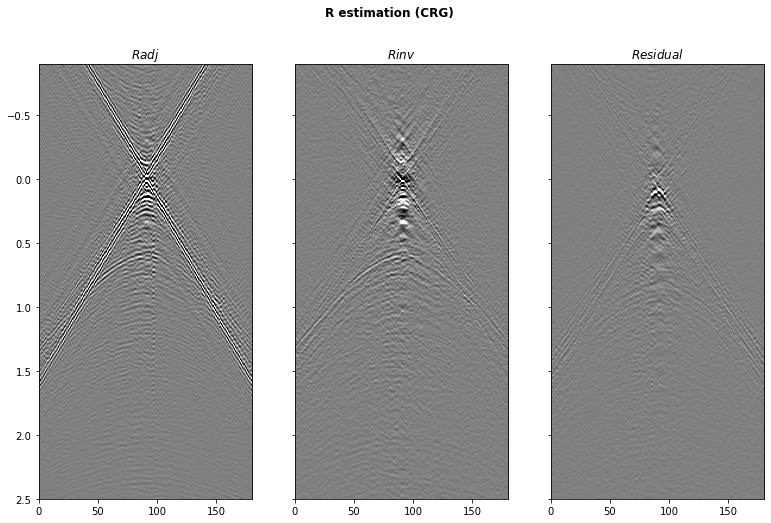

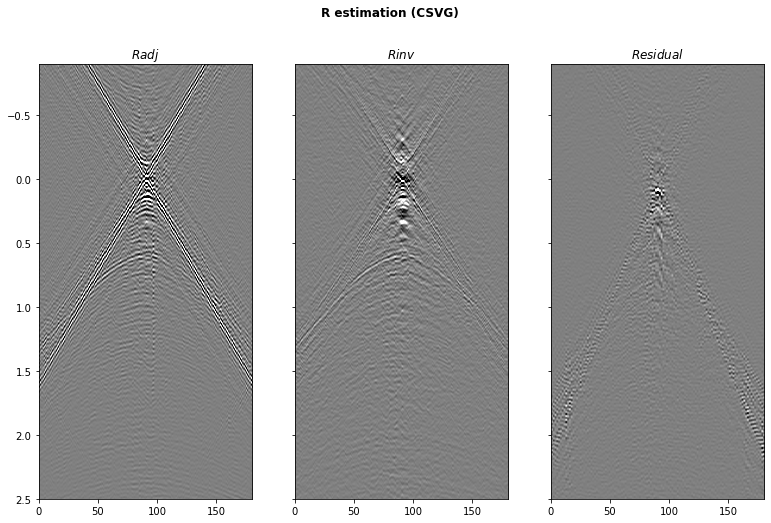

In [30]:
clip = 0.1
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj[:, nrecs//2], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj[:, nrecs//2]).max(), vmax=clip*np.abs(Radj[:, nrecs//2]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[:, nrecs//2], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, nrecs//2]).max(), vmax=clip*np.abs(Rinv[:, nrecs//2]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift((pup-pupinv)[:, nshots//2],axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, nshots//2]).max(), vmax=clip*np.abs(pup[:, nshots//2]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(2.5, -.9)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CSVG)', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj[:,  :, ivs+nvsin], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj[:,  :, ivs+nvsin]).max(), vmax=clip*np.abs(Radj[:,  :, ivs+nvsin]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[:, :, ivs], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, :, ivs+nvsin]).max(), vmax=clip*np.abs(Rinv[:, :, ivs+nvsin]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift((pup-pupinv)[:, :, ivs],axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, :, ivs]).max(), vmax=clip*np.abs(pup[:, :, ivs]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(2.5, -.9);

### Stochastic MDD

In [31]:
nepochs = niter
batch_size = 32

no_of_batches = int(np.ceil(nshots/batch_size))
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
mdict = {}
ddict = {}

In [32]:
# Identify learning-rate based on steepest descent first step / analytical upper bound.
# To make it equivalent to analytic steepest descent, denominator compensates for 
# different norm used in torch which is normalized by number of elements
lrstmax = alphamax # from steepest descent notebook
lrstmax * ((nt*nvs*nshots)/2)

8316.023417536853

In [33]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[:, :, nvsin:nvsend])

In [34]:
lr = {}

# all vs
lr[32] = 1500.

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, ivstrue=ivs, 
                              seed=0, epochprint=5, reciprocity=True,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()
ddict["SGD"] = dmod.detach().numpy()

Initial Gradient norm: 2.209405e-10, scaled by lr: 4.971161e-04
Initial Gradient norm as np.linalg.norm: 1.284255e+02, scaled by nbatches:  4.775825e+02
epoch:   5, loss : 1.6254e-06, loss avg : 1.8581e-06
epoch:  10, loss : 1.8077e-06, loss avg : 1.5179e-06
epoch:  15, loss : 1.3856e-06, loss avg : 1.3156e-06
epoch:  20, loss : 1.2810e-06, loss avg : 1.2061e-06
epoch:  25, loss : 1.2188e-06, loss avg : 1.1348e-06
epoch:  30, loss : 9.9034e-07, loss avg : 1.0714e-06
epoch:  35, loss : 1.0254e-06, loss avg : 1.0385e-06
epoch:  40, loss : 8.3642e-07, loss avg : 9.9679e-07
Final Model norm: 2.548501e-01


In [35]:
# First loss 
np.sum(np.abs(pup.reshape(-1).numpy())**2) / (len(pup.reshape(-1))), lossepochdict['SGD'][0], bench_resnorm[0]

(3.0270919642797185e-06, 3.027091964279707e-06, 3.027091964279701e-06)

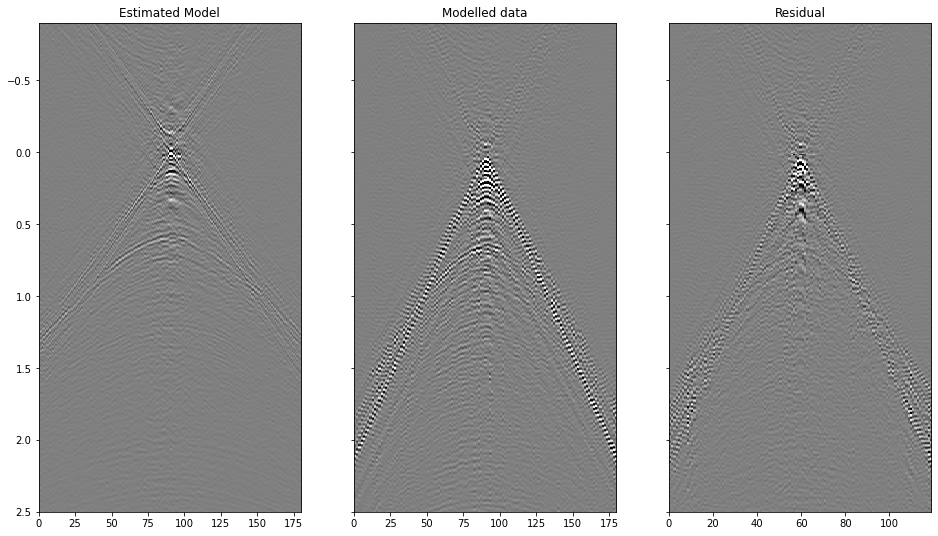

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [37]:
lr = {}

# all vs
lr[32] = 1000.

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, ivstrue=ivs, 
                              seed=0, epochprint=5, reciprocity=True,
                              **dict(lr=lr[batch_size], weight_decay=1e-8, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()
ddict["SGDMom"] = dmod.detach().numpy()

Initial Gradient norm: 2.209405e-10, scaled by lr: 2.209405e-04
Initial Gradient norm as np.linalg.norm: 1.284255e+02, scaled by nbatches:  4.775825e+02
epoch:   5, loss : 1.2657e-06, loss avg : 1.3520e-06
epoch:  10, loss : 1.3018e-06, loss avg : 1.0926e-06
epoch:  15, loss : 9.8591e-07, loss avg : 9.7917e-07
epoch:  20, loss : 1.0269e-06, loss avg : 9.3831e-07
epoch:  25, loss : 9.9028e-07, loss avg : 9.0678e-07
epoch:  30, loss : 7.9966e-07, loss avg : 8.7460e-07
epoch:  35, loss : 8.6147e-07, loss avg : 8.6633e-07
epoch:  40, loss : 7.2722e-07, loss avg : 8.4511e-07
Final Model norm: 5.072812e-01


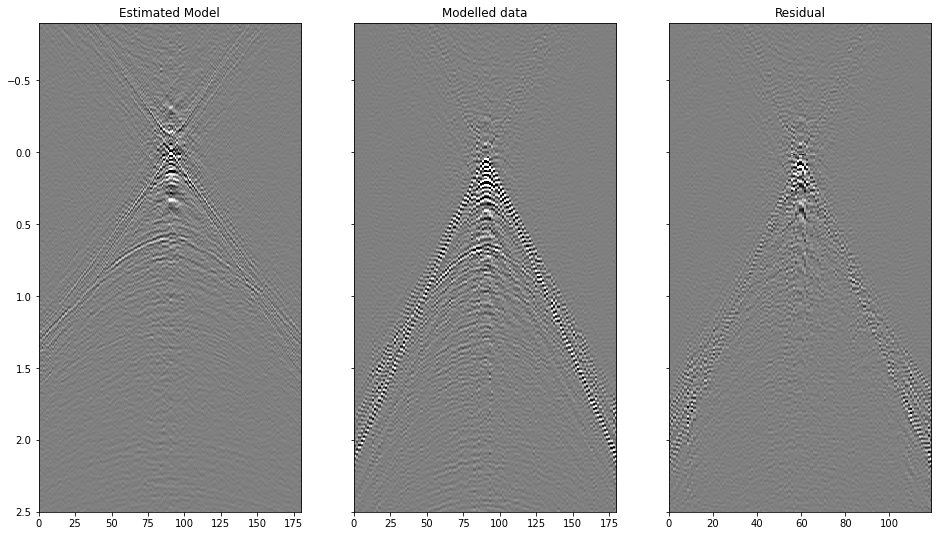

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [39]:
lr = {}

# all vs
lr[32] = 1000.

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, ivstrue=ivs, seed=0, 
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5, reciprocity=True,
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-8, momentum=0.8, nesterov=True))
mdict["SGDMom_LRexp"] = model.detach().numpy()
ddict["SGDMom_LRexp"] = dmod.detach().numpy()

Initial Gradient norm: 2.209405e-10, scaled by lr: 2.209405e-04
Initial Gradient norm as np.linalg.norm: 1.284255e+02, scaled by nbatches:  4.775825e+02
epoch:   5, loss : 1.2830e-06, loss avg : 1.3843e-06
epoch:  10, loss : 1.3459e-06, loss avg : 1.1359e-06
epoch:  15, loss : 1.0345e-06, loss avg : 1.0269e-06
epoch:  20, loss : 1.0567e-06, loss avg : 9.8554e-07
epoch:  25, loss : 1.0260e-06, loss avg : 9.5650e-07
epoch:  30, loss : 8.3309e-07, loss avg : 9.2540e-07
epoch:  35, loss : 8.9574e-07, loss avg : 9.1764e-07
epoch:  40, loss : 7.4830e-07, loss avg : 8.9799e-07
Final Model norm: 3.505674e-01


### Comparison

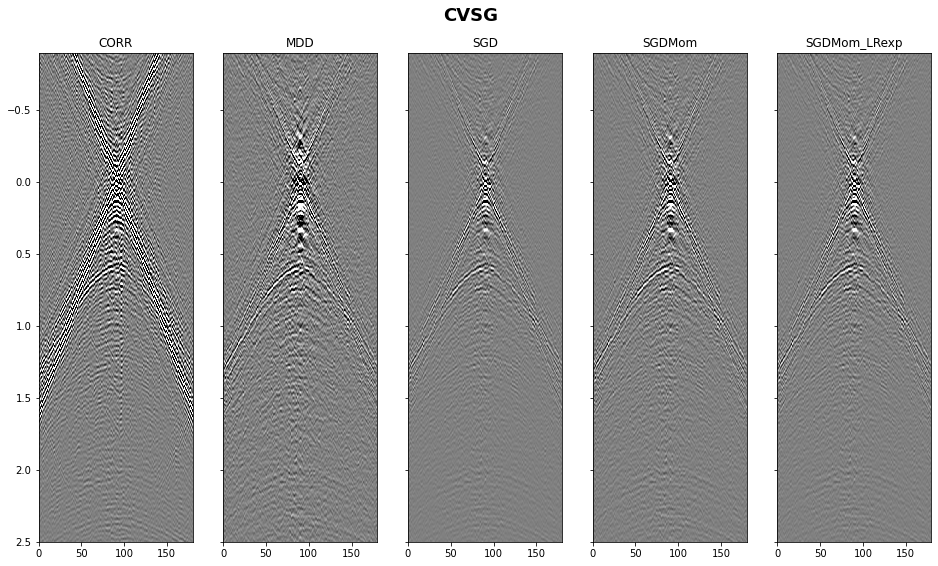

In [40]:
clip = 0.05
ivs = nvs//2

fig, axs = plt.subplots(1, 2+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CVSG', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(Radj[:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Radj[:nt, :, ivs]).max(), vmax=clip*np.abs(Radj[:nt, :, ivs]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title('CORR')
axs[1].imshow(np.fft.fftshift(Rinv[:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):

    axs[imod+2].imshow(np.fft.fftshift(mdict[mod][:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
                       extent = (0, nrecs, t[-1]/2, -t[-1]/2))
    axs[imod+2].set_title(mod)
axs[-1].set_ylim(2.5, -.9);
plt.savefig('Figs/Volvemulti_cvsg_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

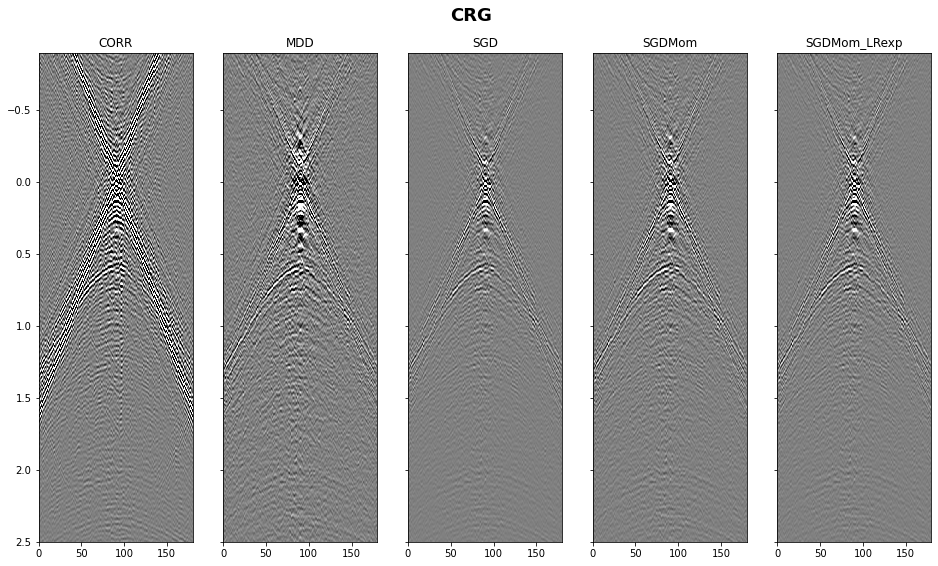

In [41]:
clip = 0.05
ir = nrecs//2

fig, axs = plt.subplots(1, 2+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CRG', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(Radj[:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Radj[:nt, ir]).max(), vmax=clip*np.abs(Radj[:nt, ir]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title('CORR')
axs[1].imshow(np.fft.fftshift(Rinv[:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[:nt, ir]).max(), vmax=clip*np.abs(Rinv[:nt, ir]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):
    axs[imod+2].imshow(np.fft.fftshift(mdict[mod][:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv[:nt, ir]).max(), vmax=clip*np.abs(Rinv[:nt, ir]).max(),
                       extent = (0, nrecs, t[-1]/2, -t[-1]/2))
    axs[imod+2].set_title(mod)
axs[-1].set_ylim(2.5, -.9);
plt.savefig('Figs/Volve_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))
plt.savefig('Figs/Volvemulti_crg_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

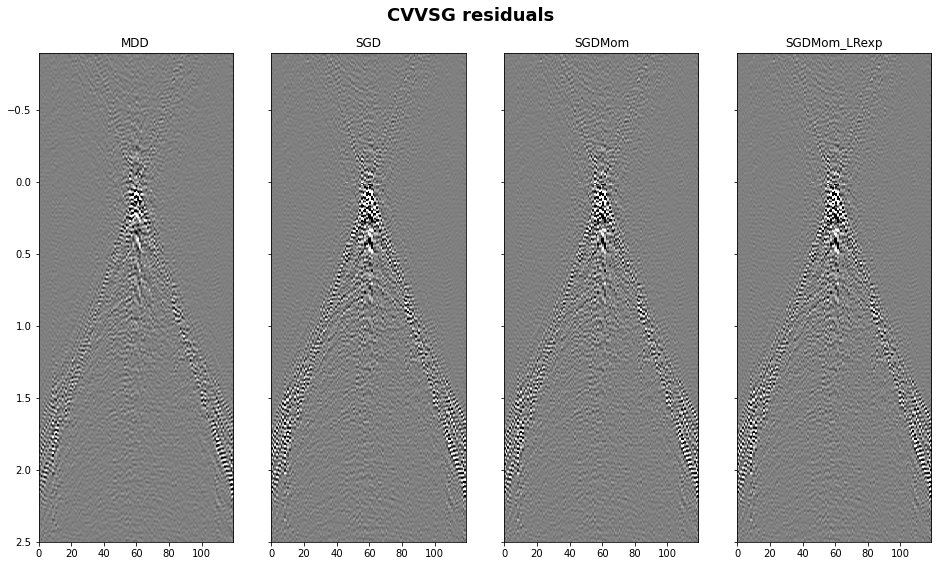

In [42]:
fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CVVSG residuals', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(pup[:, :, ivs]-pupinv[:, :, ivs], axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
              extent = (0, nshots, t[-1]/2, -t[-1]/2))
axs[0].axis('tight')
axs[0].set_title('MDD')

for imod, mod in enumerate(ddict.keys()):
    axs[imod+1].imshow(np.fft.fftshift((ddict[mod]-pup.detach().numpy())[..., ivs],axes=0), aspect='auto', 
                       interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
                       extent = (0, nshots, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
    axs[imod+1].axis('tight')

axs[-1].set_ylim(2.5, -.9);
plt.savefig('Figs/Volvemulti_cvsgres_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

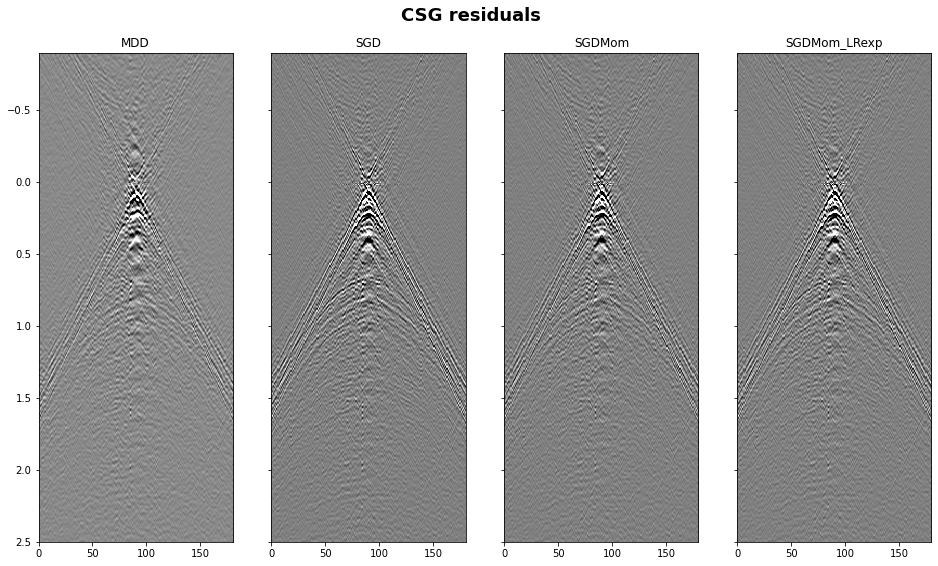

In [43]:
ishot = nshots//2

fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CSG residuals', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(pup[:, ishot]-pupinv[:, ishot], axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, ishot]).max(), vmax=clip*np.abs(pup[:, ir]).max(),
              extent = (0, nvs, t[-1]/2, -t[-1]/2))
axs[0].axis('tight')
axs[0].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):
    axs[imod+1].imshow(np.fft.fftshift((ddict[mod]-pup.detach().numpy())[:, ishot],axes=0), aspect='auto', 
                       interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(pup[:, ishot]).max(), vmax=clip*np.abs(pup[:, ishot]).max(),
                       extent = (0, nvs, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
    axs[imod+1].axis('tight')

axs[-1].set_ylim(2.5, -.9);
plt.savefig('Figs/Volvemulti_csggres_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

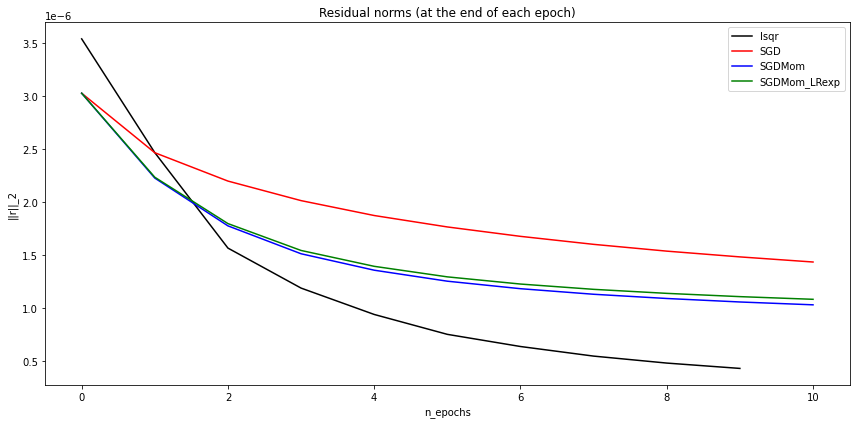

In [44]:
colors = ('r', 'b', 'g')
nepochs = 10

fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/Volvemulti_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

## Save fields

(2000, 4.0, 8.0)

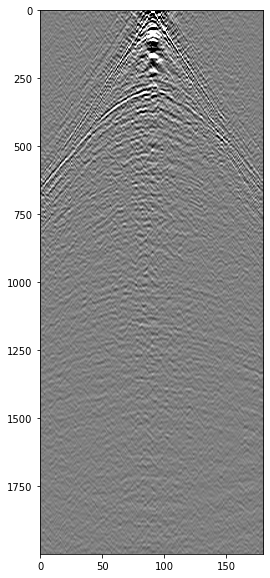

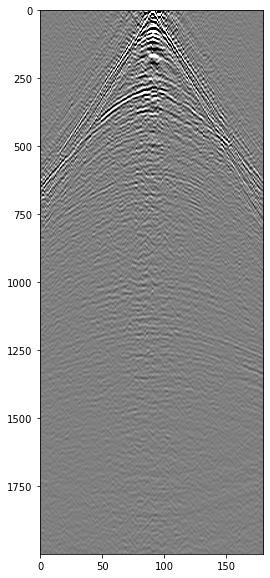

In [45]:
plt.figure(figsize=(4, 10))
plt.imshow(Rinv[:nt-1000, nrecs//2], vmin=-4e-4, vmax=4e-4, cmap='gray')
plt.axis('tight')

plt.figure(figsize=(4, 10))
plt.imshow(mdict['SGD'][:nt-1000, nrecs//2], vmin=-2e-4, vmax=2e-4, cmap='gray')
plt.axis('tight')

(nt-1000), (nt-1000)*dt, 4000*0.002

In [46]:
np.savez('Data/mdd_volvereal_multi_iter%d_batch%d_ivs%d' % (niter, batch_size, ivs), t=t,
         Radj=Radj[:, ivs], Rinv=Rinv[:, ivs], 
         Rsgd=mdict['SGD'][..., ivs], Rnsgd=mdict['SGDMom'][..., ivs], 
         Rnsgdexp=mdict['SGDMom_LRexp'][..., ivs])